# don't forget to hop into the conda3 virtual environment — source activate base

To Dos:
<ul>
    <li> make sure to add smoking to the risk factor models</li>
    <li> creatinine/GFR</li>
    <li> build out the nhanes file loader method below into something prettier</li>
</ul>

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import shutil

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
baseDir = "/Users/burke/Documents/research/bpCog/nhanes/sourceData/"
os.chdir(baseDir)

### Function to download NHANES files for specific variables

In [3]:
import wget
def downloadYear(year, stem):
    plusOne = year + 1
    dirName = "nhanesRawData/" + str(year) + "-" + str(plusOne)
    os.chdir(dirName)
    url = "https://wwwn.cdc.gov/Nchs/Nhanes/" + str(year) + "-" + str(plusOne) + "/" + stem + ".XPT"
    print(url)

    fileName = wget.download(url, stem + ".XPT")  
    # Overwrite file if already exists
    if os.path.exists(fileName):
        shutil.move(fileName,stem + ".XPT")
    os.chdir(baseDir)
    return pd.read_sas(os.path.join(dirName, stem + '.XPT'))
   

In [4]:
def loadBaseFilesForYear(year, suffix):
    # looks like OGTT dropped in 2018...
    baseFileStems = ['DEMO','MCQ', 'SMQ', 'DIQ','GHB', 'HDL', 'TCHOL', 'BMX', 'BPX', 'TRIGLY', 'BPQ']
    for baseStem in baseFileStems:
        downloadYear(year, baseStem+'_'+suffix)
    
    
# loaded for prior years manually
#loadBaseFilesForYear(1999, '')
#loadBaseFilesForYear(2001, 'B')
#loadBaseFilesForYear(2003, 'C')
#loadBaseFilesForYear(2005, 'D')
#loadBaseFilesForYear(2007, 'E')
#loadBaseFilesForYear(2009, 'F')
#loadBaseFilesForYear(2011, 'G')
#loadBaseFilesForYear(2013, 'H')
loadBaseFilesForYear(2015, 'I')
loadBaseFilesForYear(2017, 'J')

https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/MCQ_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DIQ_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/GHB_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/HDL_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/TCHOL_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/TRIGLY_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPQ_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/MCQ_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/SMQ_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DIQ_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/GHB_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/HDL_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/TCHOL_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017

In [11]:
import wget
import os.path
import shutil
     
glucoseFileStems = ['LAB10AM', 'L10_2_B','L10AM_C', 'GLU_D', 'GLU_E', 'GLU_F', 'GLU_G', 'GLU_H', 'GLU_I', 'GLU_J' ]

stemIndex = 0  
for year in range(1999,2018,2):
    downloadYear(year, glucoseFileStems[stemIndex])
    stemIndex += 1
    
    
paqFileStems = ['PAQ', 'PAQ_B','PAQ_C', 'PAQ_D', 'PAQ_E', 'PAQ_F', 'PAQ_G', 'PAQ_H', 'PAQ_I', 'PAQ_J' ]


stemIndex = 0
for year in range(1999,2018,2):
    downloadYear(year, paqFileStems[stemIndex])
    stemIndex += 1

rxFileStems = ['RXQ_RX', 'RXQ_RX_B','RXQ_RX_C', 'RXQ_RX_D', 'RXQ_RX_E', 'RXQ_RX_F', 'RXQ_RX_G', 'RXQ_RX_H', 'RXQ_RX_I', 'RXQ_RX_J' ]
stemIndex = 0
for year in range(1999,2018,2):
    downloadYear(year, rxFileStems[stemIndex])
    stemIndex += 1
    
alcFileStems = ['ALQ', 'ALQ_B','ALQ_C', 'ALQ_D', 'ALQ_E', 'ALQ_F', 'ALQ_G', 'ALQ_H', 'ALQ_I', 'ALQ_J' ]
stemIndex = 0
for year in range(1999,2018,2):
    downloadYear(year, alcFileStems[stemIndex])
    stemIndex += 1
    
bpqFileStems = ['BPQ', 'BPQ_B','BPQ_C', 'BPQ_D', 'BPQ_E', 'BPQ_F', 'BPQ_G', 'BPQ_H', 'BPQ_I', 'BPQ_J' ]
stemIndex = 0
for year in range(1999,2018,2):
    downloadYear(year, bpqFileStems[stemIndex])
    stemIndex += 1


https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/LAB10AM.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2001-2002/L10_2_B.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/L10AM_C.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/GLU_D.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/GLU_E.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/GLU_F.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/GLU_G.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/GLU_H.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/GLU_I.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/GLU_J.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/PAQ.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2001-2002/PAQ_B.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/PAQ_C.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAQ_D.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/PAQ_E.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/PAQ_F.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/PAQ_G.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAQ_H.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016

In [12]:
# level one gets us to cardiovascular meds...these are the level 2 value-counts
drugDatafile = downloadYear(1999, 'RXQ_DRUG')
drugDatafile['antiHypertensive'] = 0
drugDatafile['statin'] = 0
drugDatafile['otherLipidLowering'] = 0
drugDatafile.loc[((drugDatafile.RXDDCI1A==40) & (drugDatafile.RXDDCI1B.isin([42, 43, 44,47,48, 49,53,55,56]))), 'antiHypertensive'] = 1
drugDatafile.loc[((drugDatafile.RXDDCI1A==358) & (drugDatafile.RXDDCI1B == 19) & (drugDatafile.RXDDCI1C==173)), 'statin'] = 1
drugDatafile.loc[((drugDatafile.RXDDCI1A==358) & (drugDatafile.RXDDCI1B == 19) & (drugDatafile.RXDDCI1C.isin([174,241,252,316,317]))), 'otherLipidLowering'] = 1

https://wwwn.cdc.gov/Nchs/Nhanes/1999-2000/RXQ_DRUG.XPT


In [13]:
demo17 = pd.read_sas("/Users/burke/Documents/research/bpCog/nhanes/sourceData/nhanesRawData/2017-2018/DEMO_J.XPT")
meds17 = pd.read_csv("/Users/burke/Documents/research/bpCog/nhanes/sourceData/nhanesRawData/2017-2018/medSummary.csv")

In [14]:
len(demo17.SEQN.unique())

9254

In [15]:
len(meds17.SEQN.unique())

3951

### Load All NHANES Data Files and append into a single dataset



In [26]:
''' iterate through the root directory which has subdiretxories (with year names) for each annual collection of 
raw NHANES data files '''

root = next(os.walk("nhanesRawData"))[0]
yearDirs = next(os.walk("nhanesRawData"))[1]
yearDirsWithRoot = [root + os.sep + year for year in yearDirs]


# loads the files from a year — starts with the demographics files and then merges in all of the other subfiles in the directory

def loadYear(dir):
    demographics = getDemographics(dir)
    otherFiles = next(os.walk(dir))[2]
    otherFiles.remove(demographics)
    
    demoSAS = pd.read_sas(dir + os.sep + demographics)
    for other in otherFiles:
        if other[-3:] == "csv":
            otherSAS = pd.read_csv(dir + os.sep + other)
            demoSAS = demoSAS.merge(otherSAS, how='left', on=['SEQN'])
        elif other.startswith("RXQ"):
            continue
        elif other[-3:].lower() == "xpt":
            print(other)
            otherSAS = pd.read_sas(dir + os.sep + other)
            demoSAS = demoSAS.merge(otherSAS, how='left', on=['SEQN'])
    year = dir[dir.find(os.sep)+1:dir.find("-")]
    demoSAS['year'] = year
    
    # left off here — need to get date of death into this by pulling it from the file year in teh loop
    columnNameMappings = {"RIDAGEYR" : "age", "RIAGENDR" :  "gender",  "RIDRETH1" : "raceEthnicity",
                          "BPXSY1" : "sbp1", "BPXSY2" : "sbp2", "BPXSY3" : "sbp3", "BPXSY4" : "sbp4", "BPXDI1" : "dbp1",
                        "BPXDI2": "dbp2", "BPXDI3" : "dbp3", "BPXDI4" : "dbp4", "LBXGH" : "a1c", "LBDHDD" : "hdl",
                        "LBXTC" : "tot_chol", "SMQ040" : "currentSmoker", "SMQ020" : "quantitySmoked","BMXWT" : "weight",
                          "BMXBMI" : "bmi", "BMXWAIST" : "waist", "LBDLDL" : "ldl", "LBXTR" : "trig",  
                          "DMDYRSUS" : "timeInUS", "MORTSTAT" : "diedBy2015", "UCOD_LEA" : "ucod", 
                         "MCQ160E" :"selfReportMI", "MCQ180E" : "selfReportMIAge", 
                            "MCQ160F" : "selfReportStroke", "MCQ180F" : "selfReportStrokeAge", 
                          "PERMTH_I" : "monthsToDeath", "PERMTH_E" : "monthsToDeath2", "DMDEDUC2" : 'education',
                         'antiHypertensive' : 'antiHypertensive', 'statin' : 'statin', 'otherLipidLowering' : 'otherLipidLowering',
                         'PAQ605' : 'vigorousWork', 'PAQ620' : 'moderateWork', 'PAQ635' : 'walkBicyle', 
                         'PAQ650' : 'vigorousRecreation', 'PAQ665' : 'moderateRecreation',
                         'PAD020' : 'walkBikeOld', 'PAD200' : 'vigorousOld', 'PAD320' : 'moderateOld',
                         'ALQ130' : 'alcoholDrinksPerDay', 'ALQ100' : 'alcoholLastYear',
                         'ALQ110' : 'alcoholLifetime', 'RIDSTATR' : 'interviewStatus', 
                         'BPQ020' : 'selfReportHtn', 'BPQ050A': 'selfReportCurrentHtnMed'}
    
    alternateNames = {'LBXTC' : ['LBXTC_x' ], 'LBDHDD' : ['LBDHDL','LBXHDD', 'LBDHDL_x']}
    
    print (year)
    demoSAS.to_csv(str(year + "Before.csv"))
    # we have a couple variable names that get remapped to differnet names...this will remap them all to consistent names
    for key in alternateNames.keys():
        if key not in demoSAS:
            print(str(key) + " is missing from year: " + str(year))
            for value in alternateNames[key]:
                print ("checking: " + value)
                if value in demoSAS:
                    print ("rename: " + value + " to key: " + key)
                    demoSAS.rename(columns={value: key}, inplace=True)

    demoSAS.to_csv(str(year + "InBetween.csv"))

    
    columnsToKeep = list(columnNameMappings.keys())
    columnsToKeep.extend(["SEQN", "WTINT2YR", "WTMEC2YR", "SDMVPSU", "SDMVSTRA", "year"])
    
    # some of the factors that we car eabout are missing in given years...add them and make them null here.
    for value in columnsToKeep:
        if value not in demoSAS:
            demoSAS[value] = np.nan
    
    demoSAS = demoSAS[columnsToKeep]
    demoSAS.rename(columns=columnNameMappings, inplace=True)
    demoSAS.to_csv(str(year) + ".csv")
    
    return demoSAS

def getDemographics(dir):
    files = next(os.walk(dir))[2]
    for file in files:
        if file.startswith("DEMO"):
            return file
    raise Exception("Unable to find demographics file in directory: " + dir)
        
    
# the med files are going to be our exception — for all of the other files, we just need to get a single row per person
# for meds, there are multiple rows per person...so, we'll build a summary file that extracts the med fieds that we care 
# about into a summary file with one line per person
def convertMedsToMedSummaryFiles(dir):
    allFiles = next(os.walk(dir))[2]
    for file in allFiles:
        if file.startswith('RXQ_RX'):
            medsFile = pd.read_sas(os.path.join(dir, file))
            summary = medsFile.merge(drugDatafile, on='RXDDRGID').groupby('SEQN')[['SEQN', 'antiHypertensive', 'statin', 'otherLipidLowering']].sum()
            summary.to_csv(os.path.join(dir, "medSummary.csv"))
    
[convertMedsToMedSummaryFiles(x) for x in yearDirsWithRoot]
yearDataFrames = [loadYear(x) for x in yearDirsWithRoot]
combined = pd.concat(yearDataFrames, sort=True)

combined['anyPhysicalActivity'] = 0
combined.loc[(combined.vigorousWork==1) | (combined.moderateWork==1) | (combined.walkBicyle==1) | (combined.vigorousRecreation==1) | (combined.moderateRecreation==1),'anyPhysicalActivity'] = 1
combined.loc[(combined.walkBikeOld==1) | (combined.vigorousOld==1) | (combined.moderateOld==1),'anyPhysicalActivity'] = 1
combined.drop(labels=['vigorousWork', 'moderateWork', 'walkBicyle', 'vigorousRecreation', 'moderateRecreation', 'walkBikeOld', 'vigorousOld', 'moderateOld'], axis=1, inplace=True)
combined.education.replace(to_replace=[7,9], value=np.nan, inplace=True)


# combine the two smoking status variables into a variable that fits into ASCVD
def generateSmokingStatus(x):
    if np.isclose(x.currentSmoker, 1, 0.0001) or np.isclose(x.currentSmoker, 2, 0.0001):
        return "2"
    elif np.isclose(x.quantitySmoked, 1, 0.0001):
        return "1"
    else:
        return "0"
    
smokingStatusValues = [generateSmokingStatus(x) for _,x in combined.iterrows()]
combined = combined.assign(smokingStatus=pd.Series(data=smokingStatusValues, index=combined.index, dtype="category"))
combined.drop(labels=["currentSmoker", "quantitySmoked"],axis=1, inplace=True)
combined.raceEthnicity = combined.raceEthnicity.astype('int')
combined.raceEthnicity = combined.raceEthnicity.astype("category")
combined.education.fillna(4, inplace=True) # small amount of mnissing data...will crudely impute with temost common value
combined[['education']] = combined[['education']].astype('int')
combined.education = combined.education.astype('category')

combined['meanSBP'] = combined[['sbp1', 'sbp2', 'sbp3', 'sbp4']].mean(axis=1)
combined['meanDBP'] = combined[['dbp1', 'dbp2', 'dbp3', 'dbp4']].mean(axis=1)

combined['alcoholPerWeek'] = combined.alcoholDrinksPerDay * 7
combined.alcoholPerWeek= np.where(combined.alcoholLastYear ==2, 0, combined.alcoholPerWeek)
combined.alcoholPerWeek = np.where(combined.alcoholLifetime ==2, 0, combined.alcoholPerWeek)
combined.alcoholPerWeek = np.where(combined.alcoholDrinksPerDay > 40, np.nan, combined.alcoholPerWeek)

combined['completedInterview'] = 0
combined.loc[combined.interviewStatus==2,'completedInterview'] = 1

# there are a bunch of very low DBPs that don't correlate with SBPs at all...we're going to call those missing
# and then impute them
combined.loc[combined.meanDBP < 40, 'meanDBP'] = np.nan
combined['year'] = combined['year'].astype('int')
combined['missingSBP'] = combined.meanSBP.isna()

# get some information for anti-hypertensifes to help imputatino...
combined.loc[combined['selfReportHtn'] !=1, 'selfReportHtn'] = 0
combined.loc[combined['selfReportCurrentHtnMed'] !=1, 'selfReportCurrentHtnMed'] = 0


### Clean up some variables with muitple field names and build a smoking summary variable
over18 = combined.loc[combined.age >= 18]


TRIGLY_G.XPT
BPQ_G.XPT
SMQ_G.XPT
ALQ_G.XPT
GHB_G.XPT
DIQ_G.XPT
MCQ_G.XPT
PAQ_G.XPT
TCHOL_G.XPT
2011mortality.xpt
HDL_G.XPT
BMX_G.XPT
BPX_G.XPT
OGTT_G.XPT
GLU_G.XPT
2011
OGTT_I.XPT
GLU_I.XPT
BPX_I.XPT
MCQ_I.XPT
BMX_I.XPT
HDL_I.XPT
TCHOL_I.XPT
PAQ_I.XPT
DIQ_I.XPT
GHB_I.XPT
ALQ_I.XPT
SMQ_I.XPT
BPQ_I.XPT
TRIGLY_I.XPT
2015
BPQ_E.XPT
TRIGLY_E.XPT
DIQ_E.XPT
GHB_E.XPT
ALQ_E.XPT
SMQ_E.XPT
BMX_E.XPT
HDL_E.XPT
TCHOL_E.XPT
PAQ_E.XPT
MCQ_E.XPT
BPX_E.XPT
GLU_E.XPT
2007Mortality.xpt
OGTT_E.XPT
2007
DIQ_C.XPT
GHB_C.XPT
ALQ_C.XPT
SMQ_C.XPT
BPQ_C.XPT
BMX_C.XPT
PAQ_C.XPT
MCQ_C.XPT
LDL_TRIG.XPT
L10AM_C.XPT
2003Mortality.xpt
CHOL_HDL.XPT
BPX_C.XPT
2003
LBDHDD is missing from year: 2003
checking: LBDHDL
checking: LBXHDD
rename: LBXHDD to key: LBDHDD
checking: LBDHDL_x
2009Mortality.xpt
BPQ_F.XPT
TRIGLY_F.XPT
DIQ_F.XPT
GHB_F.XPT
ALQ_F.XPT
SMQ_F.XPT
MCQ_F.XPT
BMX_F.XPT
HDL_F.XPT
TCHOL_F.XPT
PAQ_F.XPT
BPX_F.XPT
OGTT_F.XPT
GLU_F.XPT
2009
SMQ_B.XPT
ALQ_B.XPT
DIQ_B.XPT
BPQ_B.XPT
GHB.XPT
PAQ_B.XPT
HDL_TOT.XPT
BMX_

In [27]:
pd.crosstab(combined.selfReportCurrentHtnMed, combined.year)

year,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017
selfReportCurrentHtnMed,,,,,,,,,,
0.0,8896,9856,8831,9188,8478,8795,8235,8589,8404,7604
1.0,1069,1183,1291,1160,1671,1742,1521,1586,1567,1650


In [28]:
pd.crosstab(combined.selfReportHtn, combined.selfReportCurrentHtnMed)

selfReportCurrentHtnMed,0.0,1.0
selfReportHtn,,
0.0,81882,0
1.0,4994,14440


In [29]:
combined.selfReportHtn.value_counts()

0.0    81882
1.0    19434
Name: selfReportHtn, dtype: int64

In [30]:
combined.completedInterview.value_counts()

1    96766
0     4550
Name: completedInterview, dtype: int64

In [31]:
# this aligns with the total nmumber that get interview or exam...https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm
# and the 8704 aligns with the total number that completed the interview in the JAMA paper: https://cdn.jamanetwork.com/ama/content_public/journal/jama/938557/joi200090supp1_prod_1600712145.41674.pdf?Expires=1627414089&Signature=lVm5OOLRJnT8mMvVXLkb9MwC7~Bj02SLlQpYb-hRes5teUgXAARaw33lkRZtkmD-bW3wtlCThEQJITXs8erWnC~t-yWDNatjg3ZUprHTtBQjtY4Iikbnf0LW1ycXEvid8AlKUWAZAN7O94~bgBU178sgIk5Te~Bzl1kHPu-WyOPKiHGKqsmJ7TcN5ohE4nJewBcbnOpXMXHsK4yDWmkH9Ys-30HLZ2nBIRhPqAOa5EuO9Y2dY4KP1V2Nc-IN~bw-WDvLXocEcPtRCv71bL1OTAQN1Lxrp-QL4aFokowmWKuNWpVhI7KVvVJcmf74HcnHC2~41yGpi0PIaHYGWXFO4g__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA
print(len(combined.loc[combined.year==2017]))
print(combined.loc[combined.year==2017].completedInterview.value_counts())

9254
1    8704
0     550
Name: completedInterview, dtype: int64


In [32]:
over18['htn3'] = 0
over18['htn4'] = 0

over18['meanSBP3'] = over18[['sbp1', 'sbp2', 'sbp3']].mean(axis=1)
over18.loc[((over18['meanSBP'] >= 140) | (over18['meanDBP'] >= 90) | (over18['antiHypertensive'] > 0)), 'htn4'] = 1
over18.loc[((over18['meanSBP3'] >= 140) | (over18['meanDBP'] >= 90) | (over18['antiHypertensive'] > 0)), 'htn3'] = 1


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [33]:
test2017All = combined.loc[combined.year==2017]
test2017Adult = over18.loc[over18.year==2017]

In [34]:
test2017Adult.groupby('interviewStatus')[['age', 'gender', 'sbp1']].mean()
# non examined patients are slightly mnore likely to be male and slighty more likely to be older...

,age,gender,sbp1
interviewStatus,,,
1.0,51.077399,1.479876,NaN
2.0,49.816555,1.517079,125.984895


In [35]:
test2017Adult['missingSBPOnly'] = test2017Adult['missingSBP'] & (test2017Adult['interviewStatus'] == 2)
test2017Adult.groupby('missingSBPOnly')[['age', 'gender', 'meanDBP', 'bmi', 'ldl', 'waist', 'tot_chol', 'smokingStatus']].mean()

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,age,gender,meanDBP,bmi,ldl,waist,tot_chol
missingSBPOnly,,,,,,,
False,49.928225,1.512471,72.650946,29.670593,109.789519,100.152541,187.064339
True,49.056537,1.565371,NaN,30.120392,106.611570,100.454839,183.253012


In [36]:
pd.crosstab(test2017Adult.missingSBP, test2017Adult.interviewStatus)

interviewStatus,1.0,2.0
missingSBP,,
False,0,5250
True,323,283


In [37]:
# ok...it doesn't look like the problem is 3 measures vs. 4...that's not going to be a source of bias...
pd.crosstab(test2017Adult.htn3, test2017Adult.htn4)

htn4,0,1
htn3,,
0,3355,2
1,1,2498


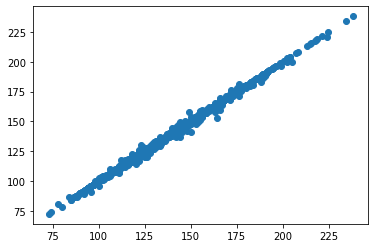

In [38]:
# 3 measures vs. 4 meaures isn't our problem...
plt.scatter(test2017Adult.meanSBP3, test2017Adult.meanSBP)

In [39]:
over18.groupby('year').apply(lambda x : x.count()) / len(over18)

,SDMVPSU,SDMVSTRA,SEQN,WTINT2YR,WTMEC2YR,a1c,age,alcoholDrinksPerDay,alcoholLastYear,alcoholLifetime,antiHypertensive,bmi,dbp1,dbp2,dbp3,dbp4,diedBy2015,education,gender,hdl,interviewStatus,ldl,monthsToDeath,monthsToDeath2,otherLipidLowering,raceEthnicity,sbp1,sbp2,sbp3,sbp4,selfReportCurrentHtnMed,selfReportHtn,selfReportMI,selfReportMIAge,selfReportStroke,selfReportStrokeAge,statin,timeInUS,tot_chol,trig,ucod,waist,weight,year,anyPhysicalActivity,smokingStatus,meanSBP,meanDBP,alcoholPerWeek,completedInterview,missingSBP,htn3,htn4,meanSBP3
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999,0.092021,0.092021,0.092021,0.092021,0.092021,0.079572,0.092021,0.044862,0.070282,0.023782,0.044524,0.082815,0.073323,0.072360,0.070806,0.017229,0.091936,0.092021,0.092021,0.078001,0.092021,0.033562,0.091936,0.083981,0.044524,0.092021,0.073323,0.072360,0.070823,0.017229,0.092021,0.092021,0.082427,0.003733,0.082427,0.003209,0.044524,0.024981,0.078018,0.038156,0.092021,0.081109,0.083069,0.092021,0.092021,0.092021,0.081160,0.079082,0.062462,0.092021,0.092021,0.092021,0.092021,0.080957
2001,0.101226,0.101226,0.101226,0.101226,0.101226,0.089470,0.101226,0.050351,0.000000,0.025032,0.051686,0.088322,0.082596,0.079944,0.079201,0.016266,0.101091,0.101226,0.101226,0.087916,0.101226,0.039322,0.101091,0.094318,0.051686,0.101226,0.082596,0.079944,0.079201,0.016266,0.101226,0.101226,0.091379,0.004358,0.091379,0.003446,0.051686,0.020877,0.087916,0.043781,0.101226,0.089099,0.089926,0.101226,0.101226,0.101226,0.089352,0.087021,0.062445,0.101226,0.101226,0.101226,0.101226,0.088980
2003,0.094926,0.094926,0.094926,0.094926,0.094926,0.085265,0.094926,0.045588,0.000000,0.022921,0.051652,0.087815,0.073086,0.068999,0.067918,0.018191,0.094757,0.094926,0.094926,0.084285,0.094926,0.039626,0.094757,0.089403,0.051652,0.094926,0.073086,0.068999,0.067918,0.018191,0.094926,0.094926,0.085129,0.004628,0.085129,0.003581,0.051652,0.019289,0.084302,0.040639,0.094926,0.084471,0.088136,0.094926,0.094926,0.094926,0.083491,0.081717,0.056179,0.094926,0.094926,0.094926,0.094926,0.083001
2005,0.093963,0.093963,0.093963,0.093963,0.093963,0.084825,0.093963,0.047666,0.000000,0.022971,0.046264,0.088457,0.077951,0.074370,0.072664,0.013428,0.093913,0.093963,0.093963,0.084386,0.093963,0.039474,0.093913,0.090045,0.046264,0.093963,0.077951,0.074370,0.072664,0.013428,0.093963,0.093963,0.084099,0.003632,0.084099,0.003260,0.046264,0.020269,0.084386,0.040521,0.093963,0.085298,0.088710,0.093963,0.093963,0.093963,0.085417,0.083592,0.057834,0.093963,0.093963,0.093963,0.093963,0.084994
2007,0.105196,0.105196,0.105196,0.105196,0.105196,0.094757,0.105196,0.056128,0.000000,0.026400,0.059574,0.099385,0.093693,0.091447,0.090450,0.002888,0.105044,0.105196,0.105196,0.094369,0.105196,0.045250,0.105044,0.101159,0.059574,0.105196,0.093693,0.091447,0.090450,0.002888,0.105196,0.105196,0.100247,0.004763,0.100247,0.004358,0.059574,0.025758,0.094369,0.046331,0.105196,0.095348,0.099554,0.105196,0.105196,0.105196,0.096277,0.094960,0.069235,0.105196,0.105196,0.105196,0.105196,0.096243
2009,0.110246,0.110246,0.110246,0.110246,0.110246,0.101834,0.110246,0.061921,0.000000,0.024069,0.061128,0.106175,0.098760,0.099757,0.100111,0.005439,0.109959,0.110246,0.110246,0.100872,0.110246,0.048291,0.109959,0.107189,0.061128,0.110246,0.098760,0.099757,0.100111,0.005439,0.110246,0.110246,0.105027,0.004408,0.105027,0.003834,0.061128,0.029829,0.100872,0.049118,0.110246,0.101176,0.106327,0.110246,0.110246,0.110246,0.102561,0.100635,0.073323,0.110246,0.110246,0.110246,0.110246,0.102510
2011,0.099047,0.099047,0.099047,0.099047,0.099047,0.089538,0.099047,0.056314,0.000000,0.023647,0.053510,0.093321,0.086683,0.088778,0.088812,0.005642,0.098794,0.099047,0.099047,0.087612,0.099047,0.042531,0.098794,0.094639,0.053510,0.099047,0.086683,0.088778,0.088812,0.005642,0.099047,0.099047,0.093896,0.003429,0.093896,0.003868,0.053510,0.030336,0.087612,0.043325,0.099047,0.088862,0.093524,0.099047,0.099047,0.099047,0.090467,0.088845,0.069421,0.

In [58]:
regressDF = over18.copy()
#regressDF.drop("year", axis=1, inplace=True)
regressDF = pd.get_dummies(regressDF, columns =['raceEthnicity', 'smokingStatus', 'education'])
regressDF.drop(labels=['SEQN', 'WTMEC2YR', 'SDMVPSU','SDMVSTRA','interviewStatus' ],axis=1, inplace=True)
regressDF.drop(labels=['sbp1', 'sbp2','sbp3', 'sbp4','dbp1', 'dbp2', 'dbp3', 'dbp4' ],axis=1, inplace=True)
regressDF.drop(labels=['alcoholDrinksPerDay','alcoholLastYear', 'alcoholLifetime' ],axis=1, inplace=True)

regressDF.year = regressDF.year.astype(int)
regressDF.completedInterview = regressDF.completedInterview.astype(int)
regressDF.missingSBP = regressDF.missingSBP.astype(int)
regressDF.selfReportStroke = regressDF.selfReportStroke==1
regressDF.selfReportMI = regressDF.selfReportMI==1
regressDF.ucod.replace({b'010' : '1', b'005' : 2}, inplace=True)
regressDF.ucod.loc[regressDF['ucod'].isin([b'002', b'001',b'003',b'007',b'004',b'008',b'006',b'009' ])]=3
regressDF.ucod.loc[regressDF['ucod'].isin([b'',b'.'])]=0
regressDF.ucod.fillna(value=0, inplace=True)
regressDF.ucod = regressDF.ucod.astype('int64')
regressDF.selfReportMI = regressDF.selfReportMI.astype('int64')
regressDF.selfReportStroke = regressDF.selfReportStroke.astype('int64')
regressDF.diedBy2015 = regressDF.diedBy2015.fillna(0)
regressDF.diedBy2015 = regressDF.diedBy2015.astype('int64')
regressDF.selfReportHtn = regressDF.selfReportHtn.astype('int64')
regressDF.selfReportCurrentHtnMed = regressDF.selfReportCurrentHtnMed.astype('int64')
regressDF['jnc8'] = 0
regressDF.loc[((regressDF.meanSBP > 140) | (regressDF.meanDBP > 90)), 'jnc8'] = 1
regressDF.reset_index(inplace=True)
regressDF.to_stata('nonImputedDataset.dta')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [60]:
completeCase = regressDF[['WTINT2YR', 'a1c', 'age', 'antiHypertensive', 'bmi','gender', 'hdl', 'ldl', 'otherLipidLowering',
           'statin', 'tot_chol', 'trig', 'ucod', 'waist', 'weight', 'year',
       'anyPhysicalActivity', 'meanSBP', 'meanDBP', 'alcoholPerWeek',
       'raceEthnicity_1', 'raceEthnicity_2', 'raceEthnicity_3',
       'raceEthnicity_4', 'raceEthnicity_5', 'smokingStatus_0',
       'smokingStatus_1', 'smokingStatus_2', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5']].dropna()
completeCase = completeCase.merge(regressDF[list(set(regressDF.columns)- (set(completeCase.columns)))], how='left', left_index=True, right_index=True)
completeCase.to_stata('completeCaseDataset.dta')

### Use MICE to impute missing data



In [78]:
import statsmodels.imputation.mice as mice
import statsmodels.discrete.discrete_model as dm

def ols_formula(all_variables, dependent_var, vars_to_remove):
    copied_vars = all_variables.copy()
    copied_vars.remove(dependent_var)
    vars_for_formula = [var for var in copied_vars if var not in vars_to_remove ]
    fml = ''
    first = True
    for col in vars_for_formula:
        if first:
            fml = fml + col
        else:
            fml = fml + ' + ' + col
        first = False
    return fml

cols = ['a1c', 'age', 'antiHypertensive', 'bmi', 'gender', 'hdl',  'ldl',
       'otherLipidLowering', 'selfReportMI', 'selfReportStroke', 'statin',
       'timeInUS', 'tot_chol', 'trig', 'waist', 'weight', 'year',
       'anyPhysicalActivity', 'meanSBP', 'meanDBP', 'alcoholPerWeek',
       'raceEthnicity_1',
       'raceEthnicity_2', 'raceEthnicity_3', 'raceEthnicity_4',
       'raceEthnicity_5', 'smokingStatus_0', 'smokingStatus_1',
       'smokingStatus_2', 'education_1', 'education_2', 'education_3',
       'education_4', 'education_5']

imputedData = mice.MICEData(regressDF)
# have to leave LDL and trig out of each other's imputations...since their missingness is highly correlated
formulas = {}

ldlFormula = ols_formula(cols, "ldl", ["trig"])
formulas["ldl"] = ldlFormula
imputedData.set_imputer("ldl", formula=ldlFormula)

trigFormula = ols_formula(cols, "trig", ["ldl"])
formulas["trig"] = trigFormula
imputedData.set_imputer("trig", formula=trigFormula)

# antihypetensive is a poisson...
antiHypertensiveFormula = ols_formula(cols, "antiHypertensive", ["smokingStatus_0", "smokingStatus_1","smokingStatus_2"])
antiHypertensiveFormula += '+ selfReportHtn + selfReportCurrentHtnMed + jnc8 +  meanSBP*jnc8 + meanDBP*jnc8 + meanSBP*selfReportCurrentHtnMed '
formulas["antiHypertensive"] = antiHypertensiveFormula
#imputedData.set_imputer("antiHypertensive", formula=antiHypertensiveFormula, model_class=dm.Poisson)
imputedData.set_imputer("antiHypertensive", formula=antiHypertensiveFormula)


for var in ['a1c', 'hdl', 'tot_chol', 'weight','bmi','meanSBP', 'meanDBP', 'waist', 'anyPhysicalActivity', 'alcoholPerWeek', 'statin', 'otherLipidLowering']:
    formula = ols_formula(cols, var, [])
    imputedData.set_imputer(var, formula=formula)
    formulas[var] = formula

imputedData.update_all(20)

### Check missing data in imputed vs. baseline dataset...generally looks pretty good

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value enco

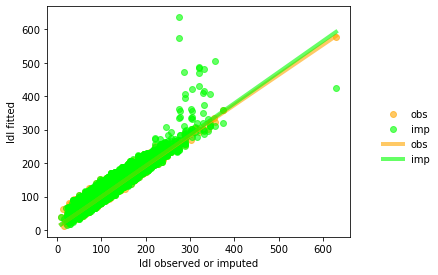

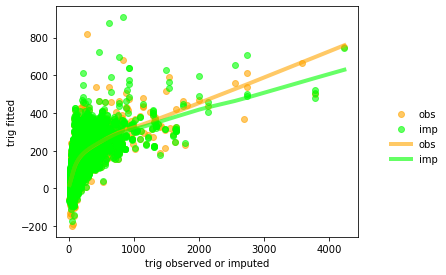

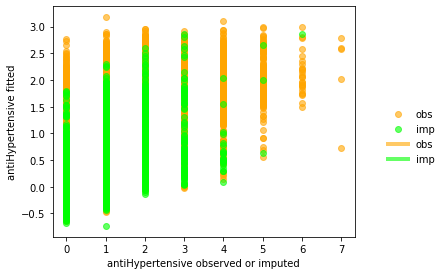

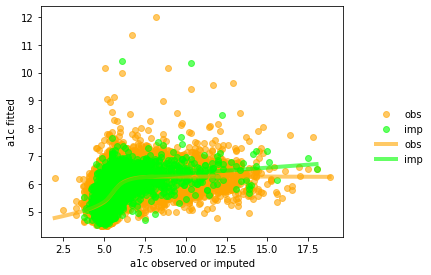

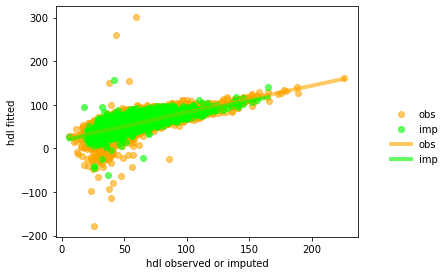

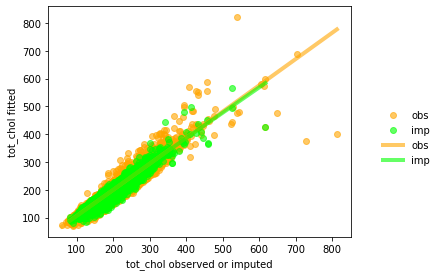

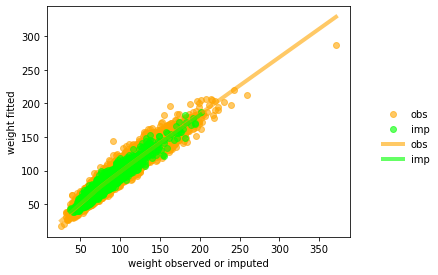

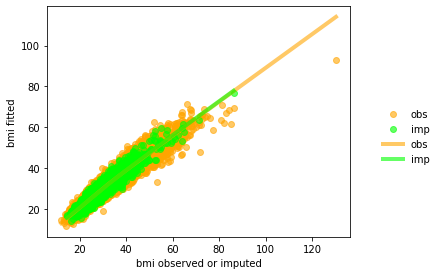

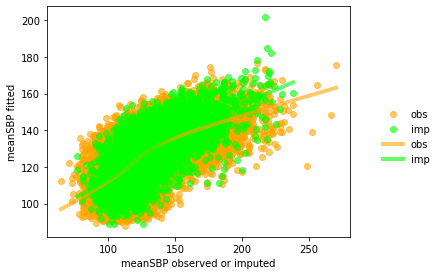

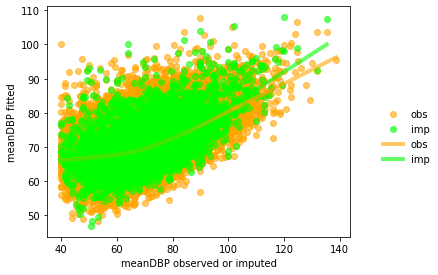

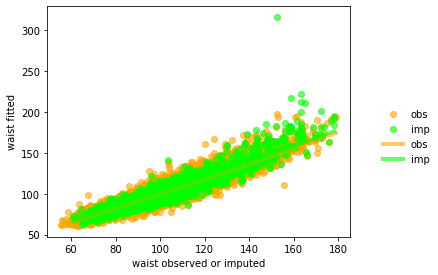

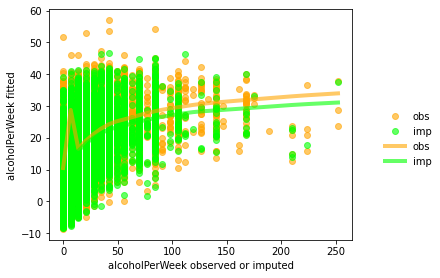

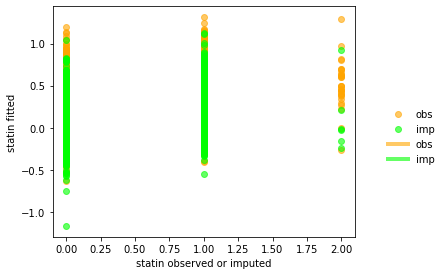

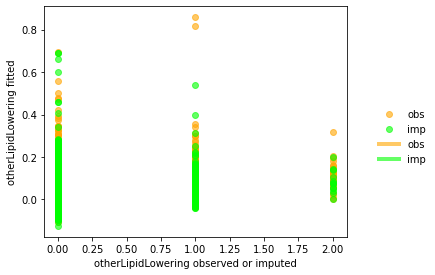

In [79]:
### look at all imputations
for var in ['ldl', 'trig', 'antiHypertensive', 'a1c', 'hdl', 'tot_chol', 'weight','bmi','meanSBP', 'meanDBP', 'waist',  'alcoholPerWeek', 'statin', 'otherLipidLowering']:
    imputedData.plot_fit_obs(var)

In [80]:
# label the xs in the regressions to make the output readable...
for var in ['ldl', 'trig', 'antiHypertensive', 'a1c', 'hdl', 'tot_chol', 'weight','bmi','meanSBP', 'meanDBP', 'waist',  'alcoholPerWeek', 'statin', 'otherLipidLowering']:
    formula = formulas[var]
    covariates = formula.split('+')
    
    count = 1
    for cov in covariates:
        imputedData.results[var].model.exog_names[count] = cov.strip()
        count+= 1

In [81]:
for var in ['ldl', 'trig', 'antiHypertensive', 'a1c', 'hdl', 'tot_chol', 'weight','bmi','meanSBP', 'meanDBP', 'waist',  'alcoholPerWeek', 'statin', 'otherLipidLowering']:
    print("\n" + var + "\n")
    print(imputedData.results[var].summary())


ldl

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     9432.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:35:27   Log-Likelihood:                -91997.
No. Observations:               24525   AIC:                         1.841e+05
Df Residuals:                   24495   BIC:                         1.843e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -314.08

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 1.600e+04
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:35:27   Log-Likelihood:            -1.6260e+05
No. Observations:               53163   AIC:                         3.253e+05
Df Residuals:                   53132   BIC:                         3.255e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -80.2013    

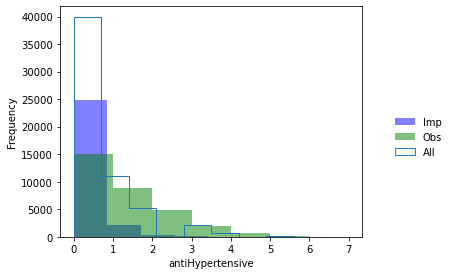

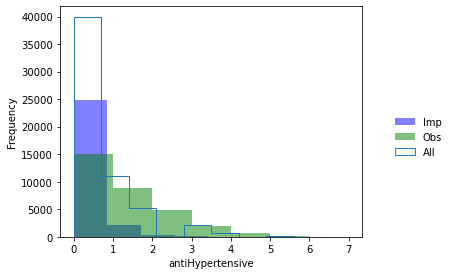

In [86]:
imputedData.plot_imputed_hist("antiHypertensive", 
                              imp_hist_args={'bins' : 7, 'alpha' : 0.5, 'color' : 'blue', 'histtype' : 'bar'},
                             obs_hist_args={'bins' : 7, 'alpha' : 0.5, 'color' : 'green', 'histtype' : 'bar'})

In [87]:
print(regressDF.meanSBP.describe())
print("\n")
print(imputedData.data.meanSBP.describe())

count    53760.000000
mean       124.104433
std         19.481820
min         64.666667
25%        110.666667
50%        120.666667
75%        134.000000
max        270.000000
Name: meanSBP, dtype: float64


count    59204.000000
mean       124.360477
std         19.762823
min         64.666667
25%        110.666667
50%        120.666667
75%        134.000000
max        270.000000
Name: meanSBP, dtype: float64


In [88]:
#over18.reset_index(inplace=True)
imputedAndBase = imputedData.data.join(over18, how='left', lsuffix='_x', rsuffix='_y')

In [89]:
imputedAndBase.groupby('missingSBP_x')[['age_x','age_y', 'meanSBP_x', 'meanSBP_y', 'meanDBP_x', 'meanDBP_y', 'antiHypertensive_x', 'antiHypertensive_y']].mean()

,age_x,age_y,meanSBP_x,meanSBP_y,meanDBP_x,meanDBP_y,antiHypertensive_x,antiHypertensive_y
missingSBP_x,,,,,,,,
0,47.530232,47.692154,123.888218,124.056861,70.550917,70.548553,0.559580,0.898185
1,49.411113,48.139879,125.717621,124.646011,70.730999,70.463571,0.565148,0.899809


In [90]:
imputedAndBase['missingAntiHypertensive'] = imputedAndBase.antiHypertensive_y.isna()
imputedAndBase.groupby('missingAntiHypertensive')[['age_x','age_y', 'meanSBP_x', 'meanSBP_y', 'meanDBP_x', 'meanDBP_y', 'antiHypertensive_x', 'antiHypertensive_y']].mean()

,age_x,age_y,meanSBP_x,meanSBP_y,meanDBP_x,meanDBP_y,antiHypertensive_x,antiHypertensive_y
missingAntiHypertensive,,,,,,,,
False,47.809380,56.384237,123.797248,128.191668,70.56344,70.876439,0.595421,0.898319
True,47.646322,37.747354,124.152437,119.344084,70.56796,70.155626,0.545307,NaN


In [32]:
### ok...so, we have problems with imputation...
### the means amongst those that are missing are too high...
### the anti hypertensives in the iputed data (_x) are lower than in the non imputed data...

### so imputation is increasing the BPS...and redsucing anti-hypertensive treatment...

In [91]:
imputedAndBase['missingAntiHypertensive'] = imputedAndBase.antiHypertensive_y.isna()

In [92]:
imputedAndBase.groupby('missingAntiHypertensive')['meanSBP_x', 'meanDBP_x', 'antiHypertensive_x', 'meanSBP_y', 'meanDBP_y', 'antiHypertensive_y'].describe()

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


meanSBP_x                                    \
                            count        mean        std        min   
missingAntiHypertensive                                               
False                     31707.0  123.797248  18.491519  76.666667   
True                      75959.0  124.152437  19.450322  64.666667   

                                                                         \
                                25%         50%         75%         max   
missingAntiHypertensive                                                   
False                    111.333333  120.666667  133.333333  234.666667   
True                     110.666667  120.666667  134.000000  270.000000   

                        meanDBP_x                                        \
                            count      mean        std   min        25%   
missingAntiHypertensive                                                   
False                     31707.0  70.56344  11.316480  40.0  63.333333   
True                      75959.0  70.56796  11.561779  40.0  62.666667   

                                                          antiHypertensive_x  \
                               50%        75%         max              count   
missingAntiHypertensive                                                        
False                    70.666667  77.333333  138.666667            31707.0   
True                     70.666667  78.000000  138.666667            75959.0   

                                                                      \
                             mean       std  min  25%  50%  75%  max   
missingAntiHypertensive                                                
False                    0.595421  0.969738  0.0  0.0  0.0  1.0  7.0   
True                     0.545307  0.933023  0.0  0.0  0.0  1.0  7.0   

                        meanSBP_y                                           \
                            count        mean        std        min    25%   
missingAntiHypertensive                                                      
False                     28925.0  128.191668  20.602282  64.666667  114.0   
True                      24835.0  119.344084  16.885726  78.000000  108.0   

                                                       meanDBP_y             \
                                50%         75%    max     count       mean   
missingAntiHypertensive                                                       
False                    125.333333  139.333333  270.0   28256.0  70.876439   
True                     116.666667  126.666667  256.0   24501.0  70.155626   

                                                                           \
                               std   min        25%        50%        75%   
missingAntiHypertensive                                                     
False                    11.651837  40.0  63.333333  70.666667  78.000000   
True                     11.516101  40.0  62.666667  70.000000  77.333333   

                                    antiHypertensive_y                      \
                                max              count      mean       std   
missingAntiHypertensive                                                      
False                    132.000000            31707.0  0.898319  1.085481   
True                     138.666667                0.0       NaN       NaN   

                                                  
                         min  25%  50%  75%  max  
missingAntiHypertensive                           
False                    0.0  0.0  1.0  1.0  7.0  
True                     NaN  NaN  NaN  NaN  NaN

In [35]:
imputedAndBase.groupby('missingAntiHypertensive')['antiHypertensive_x',  'antiHypertensive_y'].describe()

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


antiHypertensive_x                                     \
                                     count      mean       std  min  25%  50%   
missingAntiHypertensive                                                         
False                              31707.0  0.711326  1.005077  0.0  0.0  0.0   
True                               75959.0  0.655867  0.976894  0.0  0.0  0.0   

                                  antiHypertensive_y                           \
                         75%  max              count      mean       std  min   
missingAntiHypertensive                                                         
False                    1.0  7.0            31707.0  0.898319  1.085481  0.0   
True                     1.0  7.0                0.0       NaN       NaN  NaN   

                                             
                         25%  50%  75%  max  
missingAntiHypertensive                      
False                    0.0  1.0  1.0  7.0  
True                     NaN  NaN  NaN  NaN

In [36]:
### in general...imputation is really really important for meds because we have a ton of missing...

### so, this is weird...blood pressures are much lower in those with missing meds...
### and meds are much lower in those with missing meds (boht of which seem to make sense)
### blood pressures are higher in those with missing blood pressures
### and blood pressure meds are lower in those with missing blood pressures...

### so, we end up with slightly higher incidence of hypertensino (that makes sense frmo the higher BPs in those with missing BPs — which is semi justifiable beacuse they have older ages...0
### and we have much worse BP control — that also makes sense beacuse blood pressure meds are lower in those with missing BPs, in spite of the higher BPs...

### my guess iis that the problem is that our imputation models suck when you're missing both?


In [37]:
### imputed values are slightly higher than non-imputed values...that seesm ok...mostly by bringing upu the floor

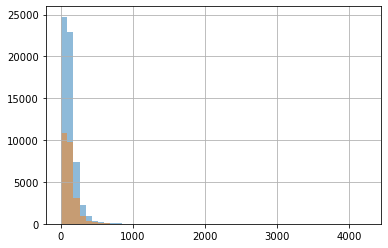

In [38]:
%matplotlib inline
imputedData.data.trig.hist(alpha=0.5, bins=50)
regressDF.trig.hist(alpha=0.5, bins=50)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:215: RuntimeWarning: invalid value encountered in true_divide
  frac=frac, it=it, delta=delta, given_xvals=False)


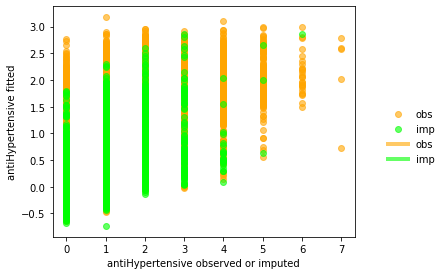

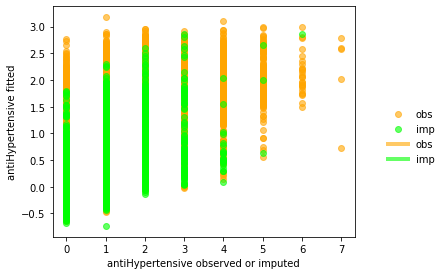

In [93]:
imputedData.plot_fit_obs("antiHypertensive")

In [40]:
len(imputedData.data)

59204

### Export imputed dataset


In [94]:
# the imputation reset the time in US variable...we actally want the nulls there because they represent people
# that have been in the US their whole lives
imputedDataset = imputedData.data
imputedDataset.timeInUS = regressDF.timeInUS.values
imputedDataset['raceEthnicity'] = over18.raceEthnicity.values
imputedDataset['smokingStatus'] = over18.smokingStatus.values
imputedDataset['education'] = over18.education.values
imputedDataset['selfReportStrokeAge'] = over18.selfReportStrokeAge.values
imputedDataset['selfReportMIAge'] = over18.selfReportMIAge.values
imputedDataset.raceEthnicity.astype("int")
imputedDataset.drop(labels=['smokingStatus_0', 'smokingStatus_1','smokingStatus_2'],axis=1, inplace=True)
imputedDataset.drop(labels=['raceEthnicity_1', 'raceEthnicity_2','raceEthnicity_3', 'raceEthnicity_4','raceEthnicity_5' ],axis=1, inplace=True)
imputedDataset.drop(labels=['education_1', 'education_2', 'education_3', 'education_4', 'education_5'],axis=1, inplace=True)
imputedDataset.diedBy2011 = imputedDataset.diedBy2015.astype('int')

imputedDataset.to_csv("fullyImputedDataset.csv")
imputedDataset.to_stata("fullyImputedDataset.dta")
from shutil import copyfile

copyfile("fullyImputedDataset.dta", "/Users/burke/Documents/research/bpCog/microsim/microsim/data/fullyImputedDataset.dta")

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:650: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column raceEthnicity contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  ValueLabelTypeMismatch,
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:650: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column education contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  ValueLabelTypeMismatch,


'/Users/burke/Documents/research/bpCog/microsim/microsim/data/fullyImputedDataset.dta'

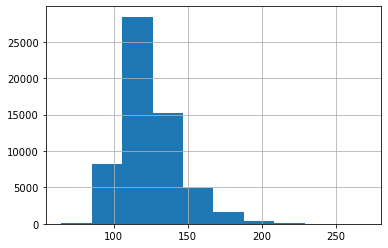

In [95]:
imputedDataset.meanSBP.hist()